# Comparation
1. GLODAP, with LAT & LON set new region (same with models)

2. plot 1D DIC / TA / TA-DIC; 14 regions plots, to compare obs & model result

<!-- 3. Try Calculate STD, plot error bar  -->

NOTE: unit: umol/L

In [1]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'monospace',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

    - region set

Text(0.5, 0.98, 'colours assigned')

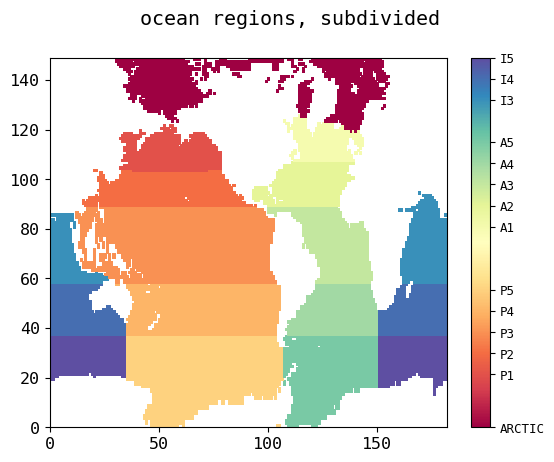

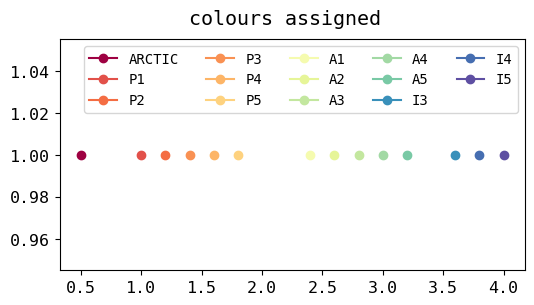

In [2]:
regs = ['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5']

regdict = {'ARCTIC' : {'number' : 0.5},
           'P1' : {'number': 1.0},
          'P2' : {'number': 1.2},
           'P3' : {'number': 1.4},
           'P4' : {'number': 1.6},
           'P5' : {'number': 1.8},
            'A1' : {'number': 2.4},
          'A2' : {'number': 2.6},
           'A3' : {'number': 2.8},
           'A4' : {'number': 3},
           'A5' : {'number': 3.2},
           'I3' : {'number': 3.6},
           'I4' : {'number': 3.8},
           'I5' : {'number': 4},
           
          }
    
tics = []
tcm = 'Spectral'
tmask = nc.Dataset('/gpfs/data/greenocean/software/resources/breakdown/clq_basin_masks_ORCA.nc')

maskno = np.zeros([149,182])
for i in range(0, len(regs)):
    maskno[tmask[regs[i]][:] == 1] = regdict[regs[i]]['number']
    tics.append(regdict[regs[i]]['number'])
maskno[maskno == 0] = np.nan


w = plt.pcolor(maskno, cmap = tcm, vmin = 0.5, vmax = 4)
cbar = plt.colorbar(w, ticks=tics)
t = cbar.ax.set_yticklabels(['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5'], fontsize = 9)
plt.suptitle('ocean regions, subdivided')

fact = 0.2
fig = plt.figure(figsize=(30*fact,15*fact))
import matplotlib
cmap = matplotlib.cm.get_cmap('Spectral')
norm = matplotlib.colors.Normalize(vmin=0.5, vmax=4)
for i in range(0,len(regs)):
    rgba = cmap(norm(regdict[regs[i]]['number']))
    plt.plot(regdict[regs[i]]['number'], 1, marker = 'o', color = rgba, label = regs[i])
    regdict[regs[i]]['colour'] = rgba
plt.legend(ncol = 5, fontsize = 10)
plt.suptitle('colours assigned')

    - mean mask

In [3]:
mean_masks = np.zeros([len(regs), 149, 182])
for i, reg in enumerate(regs):
    mean_masks[i][maskno == regdict[reg]['number']] = 1

# (1) GLODAP, with LAT & LON set new region (same with models)

    - obs data loading

In [4]:
df = pd.read_csv('/gpfs/home/mep22dku/scratch/SOZONE/evalOutput/datasets/GLODAPv2.2022_GLOBAL_valid_DICTA_umolL_STITCHED.csv')

In [5]:
# filter 1990-2020
df = df[(df.YR > 1989) & (df.YR < 2021)]
df = df[df.PRES <= 10]
df

,Unnamed: 0,YR,MONTH,DIC,ALK,SAL,TEMP,PRES,LAT,LON,Y,X,Z,Zdep,DP,REG,STATION,CRUISE
18739,18739,1990.0,5.0,2104.092014,2400.979613,35.3910,12.0020,10.000,55.61800,-19.97000,114.0,131.0,4.999938,0.0,20149.0,2.4,69.0,669.0
18759,18759,1990.0,5.0,2111.699054,2409.879257,35.4320,12.9060,10.000,52.52800,-20.00000,111.0,131.0,4.999938,0.0,19376.0,2.4,66.0,669.0
18772,18772,1990.0,5.0,2101.615389,2416.452218,35.7550,15.3070,10.000,47.05700,-19.90000,107.0,131.0,4.999938,0.0,18427.0,2.4,51.0,669.0
18776,18776,1990.0,5.0,2140.324492,2429.130210,35.9650,15.3510,10.000,38.99800,-20.00300,102.0,131.0,4.999938,0.0,15513.0,2.6,41.0,669.0
18798,18798,1990.0,5.0,2115.226922,2423.152049,35.9030,14.7890,10.000,41.00300,-19.99800,103.0,131.0,4.999938,0.0,16507.0,2.6,43.0,669.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388940,388940,2020.0,7.0,2075.801888,2313.458578,33.6795,8.6635,3.246,55.25276,-53.99350,114.0,115.0,4.999938,0.0,20008.0,2.4,66.0,4005.0
388943,388943,2020.0,7.0,2065.402333,2255.366830,32.2141,2.7871,9.934,54.95612,-54.28842,114.0,115.0,4.999938,0.0,19917.0,2.4,57.0,4005.0
388951,388951,2020.0,7.0,2030.767627,2250.484647,32.3338,7.3996,2.772,55.09360,-54.11322,114.0,115.0,4.999938,0.0,19976.0,2.4,61.0,4005.0
388952,388952,2020.0,7.0,2042.009887,2261.445162,32.5804,4.2822,9.503,55.09420,-54.11396,114.0,115.0,4.999938,0.0,19977.0,2.4,61.0,4005.0


In [6]:
tDIC = np.array(df['DIC'][:])
tALK = np.array(df['ALK'][:])

# tSAL = np.array(df['SAL'][:])
# tTEMP = np.array(df['TEMP'][:])
# tPRES = np.array(df['PRES'][:])

# dens = seawater.dens(tSAL,tTEMP,tPRES)
# tDIC_umolkg = tDIC*1000/dens
# tALK_umolkg = tALK*1000/dens

tYEAR = np.array(df['YR'])
tMONTH = np.array(df['MONTH'])
tY = np.array(df['Y'])
tX = np.array(df['X'])


    -match new region

In [7]:
tREG_new = np.array(tX)

for j in range(len(tY)):
    y = tY[j].astype(int)
    x = tX[j].astype(int)
    tREG_new[j] = maskno[y, x]

# print(tREG_new)
# len(tREG_new)

    - region mean

In [8]:
td = {}
td = {'DIC':  tDIC, 'TA':tALK, 'REG': tREG_new, 'REG_Group': tREG_new,}
tdat = pd.DataFrame(data=td)

tdat_fil = tdat[(tdat.DIC>-999) & (tdat.TA>-999) & (tdat.DIC != 0) & (tdat.TA != 0)]

tdat_fil_mean = tdat_fil.groupby(by=["REG_Group"]).mean()


# *ADD: match model and obs

# (2) Compare plots, 14 region

    2.1 read model data  -- MODEL: TOM12_TJ_GEA0

In [9]:
import glob

def make_yearlist(yrst, yrend, dtype, tr, baseDir):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{baseDir}/{tr}/ORCA2_1m_{yrs[i]}*{dtype}*.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

baseDir = '/gpfs/data/greenocean/software/runs/'
yrst = 1990
yrend = 2020 
depth = 0
dtype = 'ptrc'
modlist = ['TOM12_TJ_GEA0', 'TOM12_TJ_GEA1','TOM12_TJ_1ASA', 'TOM12_DW_WE43','TOM12_DW_GA01']


In [10]:
data_mapping = {}

for modnam in modlist:
    tylist = make_yearlist(yrst, yrend, dtype, modnam, baseDir)
    tdat = xr.open_mfdataset(tylist)

    DIC0 = tdat.DIC.isel(deptht=depth)
    TA0 = tdat.Alkalini.isel(deptht=depth)
    DIC_t = DIC0.mean(dim = ['time_counter'])
    TA_t = TA0.mean(dim = ['time_counter'])

    DIC_total_mean = np.zeros([len(regs)])
    TA_total_mean = np.zeros([len(regs),])

    for j in range(len(regs)):
            mask_data_array = xr.DataArray(mean_masks[j], dims=['y', 'x'])
            DIC_total_mean[j] = DIC_t.weighted(mask_data_array).mean(dim = ['x','y'])
            TA_total_mean[j] = TA_t.weighted(mask_data_array).mean(dim = ['x','y'])

    data_mapping[modnam] = {'TA_total_mean':  TA_total_mean, 'DIC_total_mean':DIC_total_mean}


In [11]:
data_mapping = pd.DataFrame(data=data_mapping)
data_mapping

,TOM12_TJ_GEA0,TOM12_TJ_GEA1,TOM12_TJ_1ASA,TOM12_DW_WE43,TOM12_DW_GA01
TA_total_mean,"[0.0019865848888474622, 0.002249527346290497, ...","[0.0019755909643724002, 0.0022263847518125303,...","[0.0019914686408071896, 0.002189260239490597, ...","[0.001985495202338685, 0.002254406876161741, 0...","[0.0018212096559030002, 0.002215852503273956, ..."
DIC_total_mean,"[0.0018802899849814055, 0.002062171550508292, ...","[0.0018781587998017212, 0.0020448413638284725,...","[0.0018812402092721378, 0.002022850922346638, ...","[0.0018824700733373393, 0.0020732586275693174,...","[0.001736683570128252, 0.0020328326411937566, ..."


In [12]:
# #=== For one MODEL ===

# DIC0 = tdat_GEA0.DIC.isel(deptht=0)
# TA0 = tdat_GEA0.Alkalini.isel(deptht=0)

# DIC_t = DIC0.mean(dim = ['time_counter'])
# TA_t = TA0.mean(dim = ['time_counter'])

#   # DIC_mean = np.zeros([len(regs), len(DIC0), ])
#   # TA_mean = np.zeros([len(regs), len(TA0), ])
# DIC_total_mean = np.zeros([len(regs)])
# TA_total_mean = np.zeros([len(regs),])

# for j in range(len(regs)):
#     mask_data_array = xr.DataArray(mean_masks[j], dims=['y', 'x'])
#     DIC_total_mean[j] = DIC_t.weighted(mask_data_array).mean(dim = ['x','y'])
#     TA_total_mean[j] = TA_t.weighted(mask_data_array).mean(dim = ['x','y'])    

#     # for time_i in range(len(DIC)):
#     #     DIC_mean[j][time_i] = DIC[time_i].weighted(mask_data_array).mean(dim = ['x','y'])
#     #     TA_mean[j][time_i] = TA[time_i].weighted(mask_data_array).mean(dim=['x', 'y'])

     2.2 PLOTS

In [13]:
# marker = ['^','s','v','*','X']
marker = ['o','o','o','o','o']
color = ['r','m','c','y','g']
s = 70

- DIC

Text(0, 0.5, 'Region')

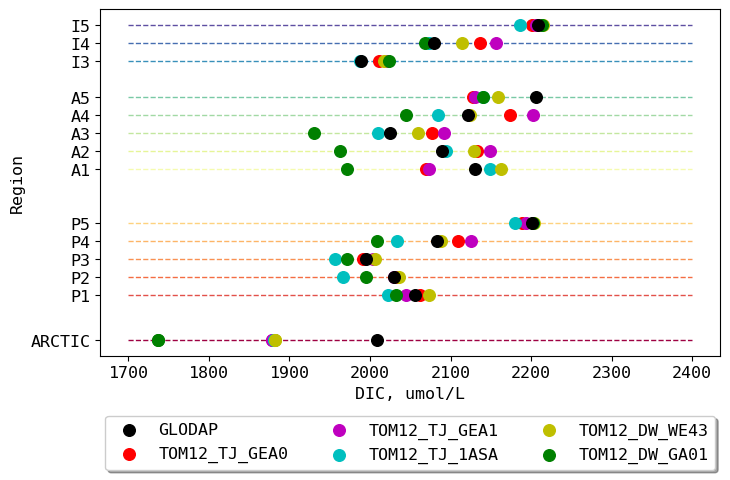

In [14]:
fig = plt.figure(figsize=(8,5))
ax = plt.subplot(111)


#GLODAP
plt.scatter(tdat_fil_mean['DIC'],tdat_fil_mean['REG'] ,marker = 'o', s=s,label = 'GLODAP',color='k', zorder=5)

# plt.plot(tdat_fil_mean['DIC'],tdat_fil_mean['REG'] ,marker = 'o', linestyle = '',markersize = 10,
#             markeredgecolor = 'k', markeredgewidth = 1,label = 'GLODAP',color='w', zorder=5)  #for black backgroud

for m, modam in enumerate(modlist):
    for i in range(0,len(regs)):
        plt.scatter(data_mapping[modam]['DIC_total_mean'][i] * 1e6, regdict[regs[i]]['number'], 
                    marker = marker[m], color=color[m],s=s, zorder=4)
    
    plt.scatter(data_mapping[modam]['DIC_total_mean'][0] * 1e6, regdict[regs[0]]['number'], 
            marker = marker[m], label = modam, color=color[m],s=s, zorder=4) # for lable

#background region line
xmin = 1700
xmax = 2400
y = (0.5, 1.0, 1.2, 1.4, 1.6, 1.8, 2.4, 2.6, 2.8, 3, 3.2, 3.6, 3.8, 4)
labels = ['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5']

for i in range(0,len(regs)):
    rgba = cmap(norm(regdict[regs[i]]['number']))
    plt.hlines(y=regdict[regs[i]]['number'], 
               xmin=xmin, 
               xmax=xmax, 
                colors = rgba, linestyles='--', lw=1, zorder=-4)

    # plt.plot(xmin,regdict[regs[i]]['number'], 
    #          color = rgba, label = regs[i],zorder=-3)        # line legend
    regdict[regs[i]]['colour'] = rgba


# y label
plt.yticks(y, labels) #rotation='vertical')


# legend position
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=3) # Put a legend below current axis

# ax.set_facecolor("black")

# plt.title(f'{yrst}-{yrend} Surface TA vs. DIC, TOM12_TJ_GEA0')
plt.xlabel('DIC, umol/L')
plt.ylabel('Region')


- TA

Text(0, 0.5, 'Region')

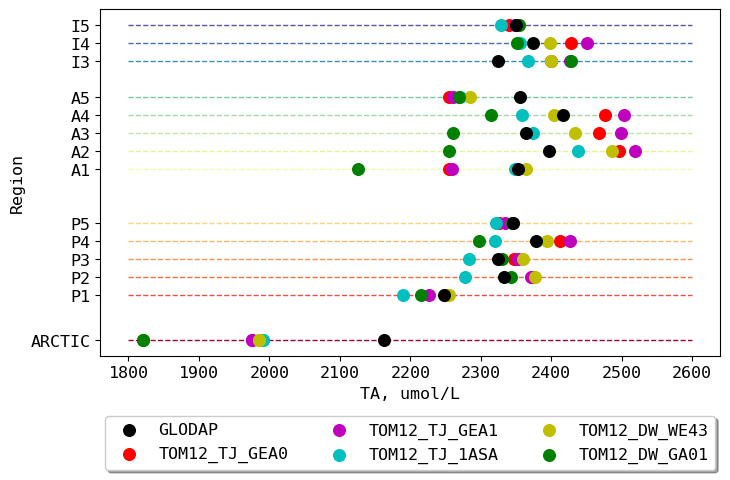

In [15]:
fig = plt.figure(figsize=(8,5))
ax = plt.subplot(111)


#GLODAP
plt.scatter(tdat_fil_mean['TA'],tdat_fil_mean['REG'] ,marker = 'o', s=s,label = 'GLODAP',color='k', zorder=5)

for m, modam in enumerate(modlist):
    for i in range(0,len(regs)):
        plt.scatter(data_mapping[modam]['TA_total_mean'][i] * 1e6, regdict[regs[i]]['number'], 
                    marker = marker[m], color=color[m],s=s, zorder=4)
    
    plt.scatter(data_mapping[modam]['TA_total_mean'][0] * 1e6, regdict[regs[0]]['number'], 
            marker = marker[m], label = modam, color=color[m],s=s, zorder=4) # for lable

#background region line
xmin = 1800
xmax = 2600
for i in range(0,len(regs)):
    rgba = cmap(norm(regdict[regs[i]]['number']))
    plt.hlines(y=regdict[regs[i]]['number'], 
               xmin=xmin, 
               xmax=xmax, 
                colors = rgba, linestyles='--', lw=1, zorder=-5)
    # plt.plot(xmin,regdict[regs[i]]['number'], 
    #          color = rgba, label = regs[i],zorder=-4)        # for legend
    regdict[regs[i]]['colour'] = rgba

# y label
plt.yticks(y, labels) #rotation='vertical')

# legend position
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=3) # Put a legend below current axis


plt.xlabel('TA, umol/L')
plt.ylabel('Region')


- TA - DIC

Text(0, 0.5, 'Region')

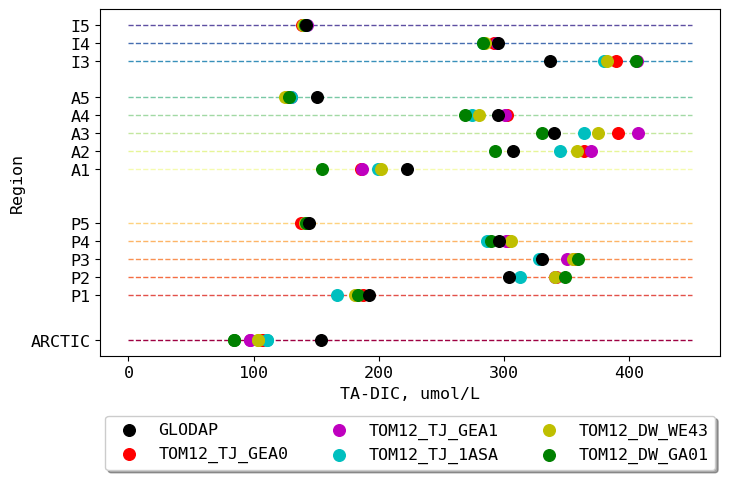

In [16]:
fig = plt.figure(figsize=(8,5))
ax = plt.subplot(111)


#GLODAP
plt.scatter(tdat_fil_mean['TA'] - tdat_fil_mean['DIC'],tdat_fil_mean['REG'] ,marker = 'o',s=s, label = 'GLODAP',color='k', zorder=5)

for m, modam in enumerate(modlist):
    for i in range(0,len(regs)):
        plt.scatter((data_mapping[modam]['TA_total_mean'][i]-data_mapping[modam]['DIC_total_mean'][i]) * 1e6, 
                    regdict[regs[i]]['number'], 
                    marker = marker[m], color=color[m],s=s, zorder=4)
    
    plt.scatter((data_mapping[modam]['TA_total_mean'][0]-data_mapping[modam]['DIC_total_mean'][0]) * 1e6, regdict[regs[0]]['number'], 
            marker = marker[m], label = modam, color=color[m],s=s, zorder=4) # for lable


#background region line
xmin = 0
xmax = 450
for i in range(0,len(regs)):
    rgba = cmap(norm(regdict[regs[i]]['number']))
    plt.hlines(y=regdict[regs[i]]['number'], 
               xmin=xmin, 
               xmax=xmax, 
                colors = rgba, linestyles='--', lw=1, zorder=-5)
    # plt.plot(xmin,regdict[regs[i]]['number'], 
    #          color = rgba, label = regs[i],zorder=-4)        # for legend
    regdict[regs[i]]['colour'] = rgba

# y label
plt.yticks(y, labels) #rotation='vertical')

# legend position
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=3) # Put a legend below current axis


plt.xlabel('TA-DIC, umol/L')
plt.ylabel('Region')
